<a href="https://colab.research.google.com/github/CesarGarcia1995/reduccion_datos_ecfm/blob/main/Examen_FInal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examen Final



El objetivo principal es predecir el flujo de calor crítico (CHF) en sistemas de ebullición bifásica, basandonos en el paper *On the prediction of critical heat flux using a physics-informed machine learning-aided framework*, para lograr este objetivo vamos a utilizar :

- Modelos de machine learning (Linear Regression, Random Forest y Redes Neuronales),


La predicción del CHF se hace usando las siguientes variables independientes:

- Presión (P)

- Flujo másico (G)

- Calidad del flujo (xe)

- Diámetro hidráulico (De)

- Diámetro calefaccionado (Dh)

- Longitud calefaccionada (Lh)

Y el target es:

- CHF (flujo de calor crítico experimental)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

## Cargando Datos

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



🔍 Resultados para: Linear Regression
MAE : 777.8018475038848
MSE : 1338553.839817514
RMSE: 1156.9588755947698
R²  : 0.6417845200817568

🔍 Resultados para: Random Forest
MAE : 311.5549597855228
MSE : 477415.73726541555
RMSE: 690.9527749893009
R²  : 0.8722369602493033

🔍 Resultados para: MLP Regressor
MAE : 539.5662894923441
MSE : 854540.368217368
RMSE: 924.4135266304621
R²  : 0.7713132045908374


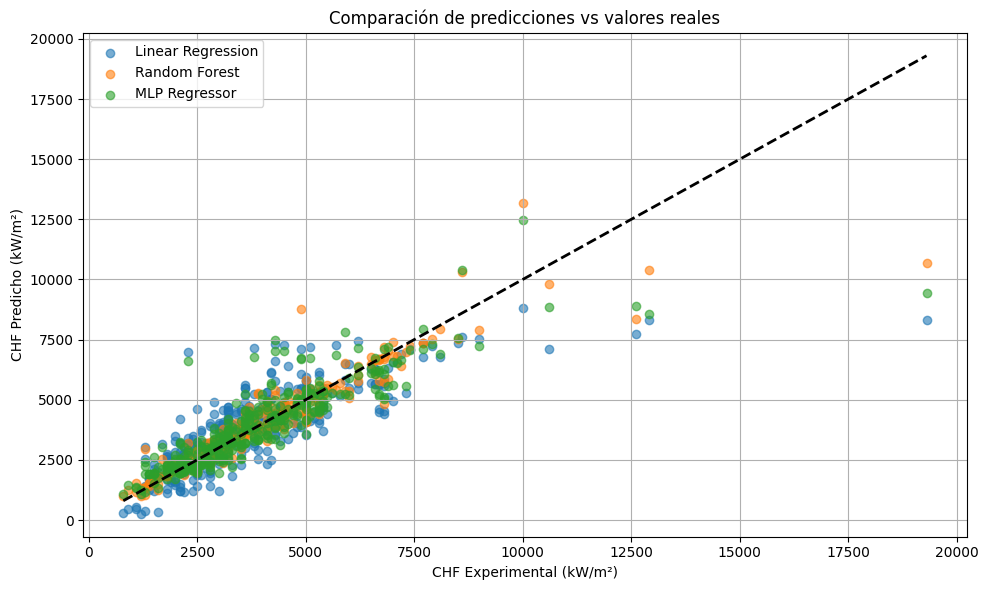

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# =======================================
# 1. CARGAR DATOS
# =======================================
df = pd.read_csv("Data_CHF_Zhao_2020_ATE.csv")

# =======================================
# 2. DEFINIR VARIABLES USANDO LOS NOMBRES CORRECTOS
# =======================================
X = df[['pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]',
        'D_e [mm]', 'D_h [mm]', 'length [mm]']]
y = df['chf_exp [MW/m2]'] * 1000  # Convertimos a kW/m2 para facilitar interpretación

# =======================================
# 3. SPLIT DE DATOS
# =======================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =======================================
# 4. ESCALADO
# =======================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =======================================
# 5. ENTRENAMIENTO DE MODELOS
# =======================================
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

mlp = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train)

# =======================================
# 6. EVALUACIÓN
# =======================================
models = {'Linear Regression': lr, 'Random Forest': rf, 'MLP Regressor': mlp}

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    print(f"\n🔍 Resultados para: {name}")
    print("MAE :", mean_absolute_error(y_test, y_pred))
    print("MSE :", mean_squared_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R²  :", r2_score(y_test, y_pred))

# =======================================
# 7. VISUALIZACIÓN DE RESULTADOS
# =======================================
plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    plt.scatter(y_test, y_pred, label=name, alpha=0.6)

plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("CHF Experimental (kW/m²)")
plt.ylabel("CHF Predicho (kW/m²)")
plt.title("Comparación de predicciones vs valores reales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1865 entries, 0 to 1864
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1865 non-null   int64  
 1   author               1865 non-null   object 
 2   geometry             1865 non-null   object 
 3   pressure [MPa]       1865 non-null   float64
 4   mass_flux [kg/m2-s]  1865 non-null   int64  
 5   x_e_out [-]          1865 non-null   float64
 6   D_e [mm]             1865 non-null   float64
 7   D_h [mm]             1865 non-null   float64
 8   length [mm]          1865 non-null   int64  
 9   chf_exp [MW/m2]      1865 non-null   float64
dtypes: float64(5), int64(3), object(2)
memory usage: 145.8+ KB


### Crear nuevas features

Vamos a agregar algunas features derivadas que aparecen en el paper y que tienen relación física:

- length_to_diameter = $\frac{length}{D_h}$

- D_ratio =  $\frac{D_e}{D_h}$

Potencialmente interacciones como mass_flux * x_e_out o términos cuadráticos.

In [15]:
# Crear variable: relación longitud a diámetro calefaccionado
df['length_to_diameter'] = df['length [mm]'] / df['D_h [mm]']

# Crear variable: relación entre diámetros hidráulico y equivalente
df['D_ratio'] = df['D_e [mm]'] / df['D_h [mm]']

# Interacción: flujo másico por calidad de salida (puede relacionarse con cambio de fase)
df['mass_flux_xe'] = df['mass_flux [kg/m2-s]'] * df['x_e_out [-]']

# Términos cuadráticos para capturar no linealidades
df['x_e_out_squared'] = df['x_e_out [-]'] ** 2
df['mass_flux_squared'] = df['mass_flux [kg/m2-s]'] ** 2
df['pressure_squared'] = df['pressure [MPa]'] ** 2


In [16]:
numerical_cols = [
    'pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]',
    'D_e [mm]', 'D_h [mm]', 'length [mm]', 'chf_exp [MW/m2]',
    'length_to_diameter', 'D_ratio'
]

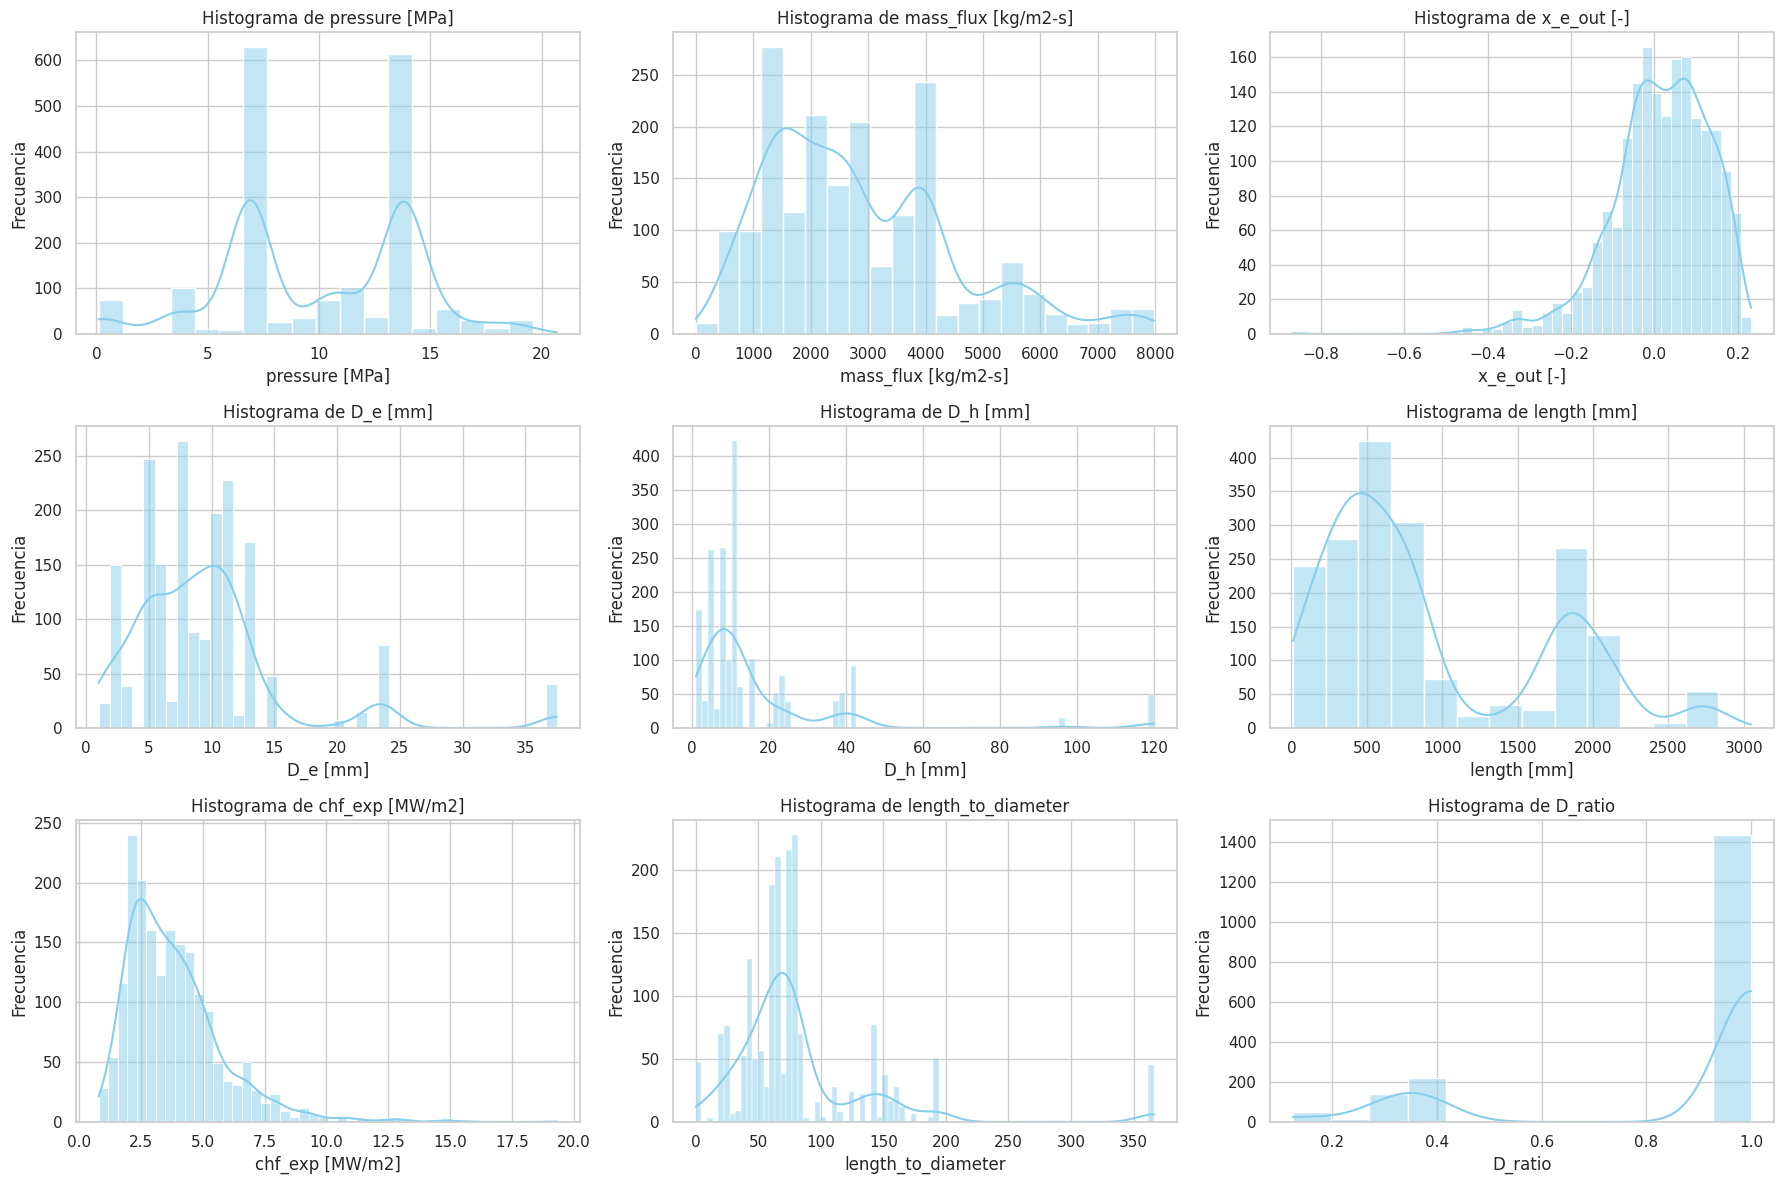

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

# Plotting histograms for each numerical column
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], ax=axes[i], kde=True, color='skyblue')
    axes[i].set_title(f'Histograma de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

# Ajustar el layout para evitar sobreposición
plt.tight_layout()

# Mostrar los gráficos
plt.show()

## Modelos de Machine Learning

En esta parte vamos a correr 4 experimentos, es decir vamos a ejecutar el entrenamiento 4 veces, pero en cada entrenamiendo vamos a cambiar los hiperparametros, incluso podemos quitar algunas variables de entrada.
Para el primer de la red neuronal experimento puedes utilizar la configuración que utilizaron en el paper:

> network architecture: optimal configuration = 6/50/50/50/1 (the input layer has 6 units, each of the 3 hidden layers has 50 units, and the output layer has 1 unit); convergence was reached after 600–800 epochs  (pagina 5)


En formato Markdown vamos a crear un registro de experimentos, el objetivo es dejar constancia de los hiperparametros utilizados en cada experimento, y las metricas de evaluacion obtenidas en cada configuración.

Para los diferentes hiperparametros debes investigar en la documentacion de sklearn cuales son los hiperparametros y como se definen en los modelos.

### Separar variables

> **Importante**: es esta sección de seleccion de variables hay libertad para seleccionar las variables numericas con las que quiero entrenar los modelos, incluso pueden variar entre experimentos, si cambio las variables de entrada debe quedar constancia en el registro de

In [22]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Selección de variables (6 variables input)
X = df[['pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]',
        'D_e [mm]', 'D_h [mm]', 'length [mm]']]
y = df['chf_exp [MW/m2]']

# División train-test (70%-30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Definición del modelo con arquitectura 6/50/50/50/1
mlp = MLPRegressor(hidden_layer_sizes=(50, 50, 50),
                   activation='relu',
                   solver='adam',
                   max_iter=800,
                   random_state=42)

# Entrenamiento
mlp.fit(X_train, y_train)

# Predicciones
y_pred = mlp.predict(X_test)

# Métricas
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.4f}')
print(f'R²: {r2:.4f}')

MSE: 3.1718
R²: 0.1571


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [24]:
numeric_features = ['pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]',
                    'D_e [mm]', 'D_h [mm]', 'length [mm]', 'length_to_diameter', 'D_ratio']


### Preprocesador

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Definir las variables numéricas
numeric_features = ['pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]',
                    'D_e [mm]', 'D_h [mm]', 'length [mm]', 'length_to_diameter', 'D_ratio']

# Separar variables de entrada y salida
X = df[numeric_features]
y = df['chf_exp [MW/m2]']

# División en train y test (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Crear preprocesador para escalar las variables numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ]
)

# Definir el modelo MLP con arquitectura 6/50/50/50/1 según el paper (aunque usas 8 variables)
# Puedes ajustar la capa de entrada o dejarlo así
mlp = MLPRegressor(hidden_layer_sizes=(50, 50, 50),
                   activation='relu',
                   solver='adam',
                   max_iter=800,
                   random_state=42)

# Crear pipeline combinando preprocesamiento y modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', mlp)
])

# Entrenar el modelo
pipeline.fit(X_train, y_train)

# Predecir con el conjunto de test
y_pred = pipeline.predict(X_test)

# Calcular métricas
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.4f}')
print(f'R²: {r2:.4f}')


MSE: 0.3382
R²: 0.9101


#### Definicion de Modelos

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'NeuralNetwork': MLPRegressor(
        hidden_layer_sizes=(50, 50, 50),
        activation='relu',
        solver='adam',
        max_iter=800,
        random_state=42
    )
}


#### Ejecutar Entrenamiento de Modelos

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline

cdf_data = {}
rRMSE_scores = {}
results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Error relativo absoluto
    relative_errors = np.abs((y_test - y_pred) / y_test)
    relative_errors = np.clip(relative_errors, 0, 1)  # Limitar errores para evitar valores extremos
    cdf_data[name] = np.sort(relative_errors)

    # Métricas
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Raíz cuadrada para RMSE
    mean_y = np.mean(y_test)
    rrmse = (rmse / mean_y) * 100  # Porcentaje

    rRMSE_scores[name] = rrmse

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'rRMSE (%)': rrmse
    })

results_df = pd.DataFrame(results)
print(results_df)


              Model       MAE      RMSE  rRMSE (%)
0  LinearRegression  0.742863  1.073875  28.246591
1      RandomForest  0.312941  0.607545  15.980512
2     NeuralNetwork  0.338828  0.581551  15.296776


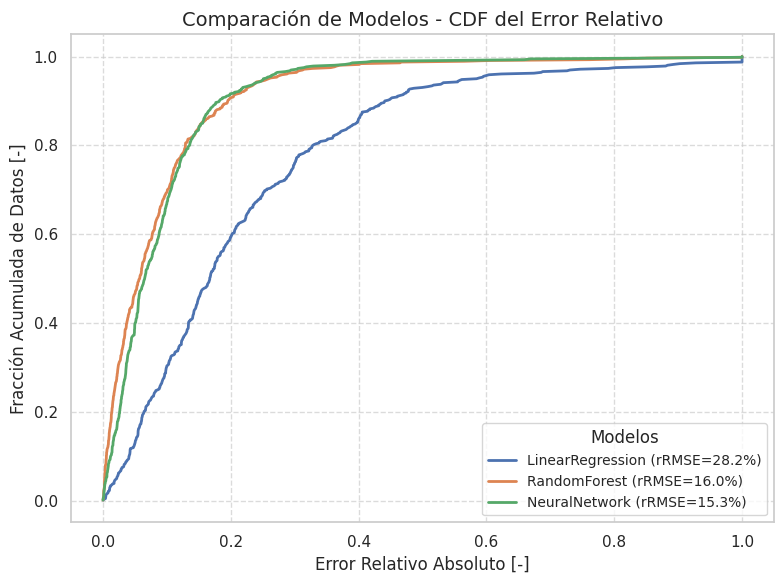

In [28]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))

for name, errors in cdf_data.items():
    cdf = np.arange(1, len(errors) + 1) / len(errors)
    plt.plot(errors, cdf, label=f"{name} (rRMSE={rRMSE_scores[name]:.1f}%)", linewidth=2)

plt.xlabel("Error Relativo Absoluto [-]", fontsize=12)
plt.ylabel("Fracción Acumulada de Datos [-]", fontsize=12)
plt.title("Comparación de Modelos - CDF del Error Relativo", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Modelos", fontsize=10)
plt.tight_layout()
plt.show()


> Compara esta grafica con la de resultados en el paper en la pagina 5, comenta acerca de los modelos

### Entrenenado un modelo de Redes Neuronales

Utiliza la mejor configuracion de hiperparametros encontrada en el entrenamiento anterior

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Definir features (X) y target (y)
X = df[numeric_features]
y = df['chf_exp [MW/m2]']

# Separar en train/test (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Preprocesador para escalar columnas numéricas
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features)
])


In [31]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor

# Definir el pipeline con preprocesador y red neuronal
mlp_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mlp', MLPRegressor(hidden_layer_sizes=(50, 50, 50), max_iter=800, random_state=42))
])

# Entrenar el modelo con los datos de entrenamiento
mlp_model.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['pressure [MPa]',
                                                   'mass_flux [kg/m2-s]',
                                                   'x_e_out [-]', 'D_e [mm]',
                                                   'D_h [mm]', 'length [mm]',
                                                   'length_to_diameter',
                                                   'D_ratio'])])),
                ('mlp',
                 MLPRegressor(hidden_layer_sizes=(50, 50, 50), max_iter=800,
                              random_state=42))])

In [33]:
# Entrenar
mlp_model.fit(X_train, y_train)

# Predecir
y_pred = mlp_model.predict(X_test)



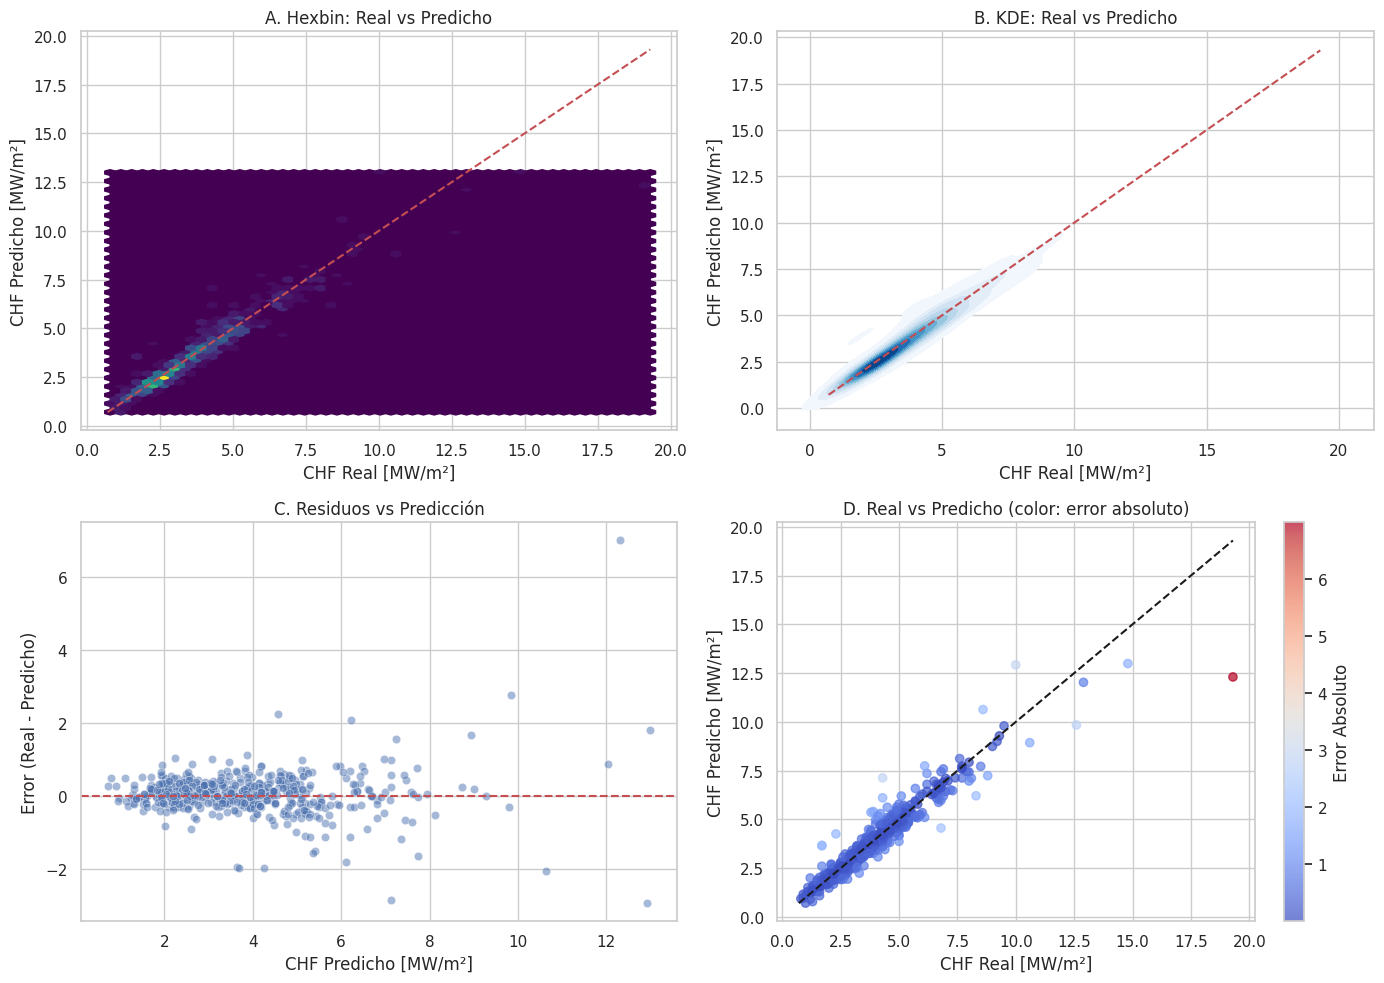

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred
abs_error = np.abs(residuals)

# Límites comunes para las líneas diagonales
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]

# Crear figura con 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# A: Hexbin plot
axes[0, 0].hexbin(y_test, y_pred, gridsize=50, cmap='viridis')
axes[0, 0].plot(lims, lims, 'r--')
axes[0, 0].set_title('A. Hexbin: Real vs Predicho')
axes[0, 0].set_xlabel("CHF Real [MW/m²]")
axes[0, 0].set_ylabel("CHF Predicho [MW/m²]")

# B: KDE scatter plot (color por densidad)
sns.kdeplot(x=y_test, y=y_pred, fill=True, cmap='Blues', ax=axes[0, 1])
axes[0, 1].plot(lims, lims, 'r--')
axes[0, 1].set_title('B. KDE: Real vs Predicho')
axes[0, 1].set_xlabel("CHF Real [MW/m²]")
axes[0, 1].set_ylabel("CHF Predicho [MW/m²]")

# C: Residual plot
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, ax=axes[1, 0])
axes[1, 0].axhline(0, color='r', linestyle='--')
axes[1, 0].set_title('C. Residuos vs Predicción')
axes[1, 0].set_xlabel("CHF Predicho [MW/m²]")
axes[1, 0].set_ylabel("Error (Real - Predicho)")

# D: Colorear por error absoluto
scatter = axes[1, 1].scatter(y_test, y_pred, c=abs_error, cmap='coolwarm', alpha=0.7)
axes[1, 1].plot(lims, lims, 'k--')
axes[1, 1].set_title('D. Real vs Predicho (color: error absoluto)')
axes[1, 1].set_xlabel("CHF Real [MW/m²]")
axes[1, 1].set_ylabel("CHF Predicho [MW/m²]")
fig.colorbar(scatter, ax=axes[1, 1], label='Error Absoluto')

plt.tight_layout()
plt.show()


> Escribe una interpretación de las graficas.

A. Hexbin: Real vs Predicho
Esta gráfica muestra la densidad de puntos (CHF real frente a CHF predicho) usando hexágonos. Los puntos se agrupan principalmente cerca de la línea diagonal roja punteada, lo que indica que las predicciones del modelo se ajustan bastante bien a los valores reales. Sin embargo, la dispersión alrededor de la diagonal muestra que hay cierto error en las predicciones, especialmente en valores más altos o bajos.

B. KDE: Real vs Predicho
El gráfico KDE resalta la densidad de los datos predichos y reales en un mapa de calor. Se observa una concentración fuerte en la región cercana a la diagonal, lo que refuerza la idea de que el modelo predice con precisión la mayoría de los datos. Las zonas más claras indican menor densidad y posiblemente donde el modelo tiene menos ejemplos para entrenar o mayor error.

C. Residuos vs Predicción
Este gráfico muestra cómo se distribuyen los errores (residuos) en función de los valores predichos. La línea horizontal en cero representa un error nulo. La dispersión simétrica y cercana a esta línea indica que el modelo no presenta sesgo sistemático (ni sobrepredicción ni subpredicción generalizadas). Si los residuos aumentaran con la predicción, se podría sospechar heterocedasticidad, pero aquí parecen estar relativamente balanceados.

D. Real vs Predicho (color: error absoluto)
Finalmente, esta gráfica muestra el error absoluto en el color del punto para cada comparación real vs predicho. Los puntos con colores más cálidos indican mayores errores absolutos. La mayoría de los puntos están en colores fríos a intermedios, lo que indica que la mayoría de las predicciones tienen un error pequeño o moderado. Sin embargo, algunos puntos aislados con colores cálidos indican casos donde el modelo tiene dificultades para predecir con precisión, lo cual puede deberse a valores atípicos o complejidades no capturadas por el modelo.